# **Support Vector Machine**


We will be using a real-world diabetes food items suggestion dataset, which contains detailed nutrition information about a food item. The objective is to classify what food a diabetic patient should choose More Often or Less Often for a specific food item given its nutrients.


## Objectives


*   Train and evaluate SVM classifiers
*   Tune important SVM hyperparameters such as regularization and kernel types
*   Plot hyperplanes and margins from trained SVM models


## SVM Overview


### Terminologies:
* Plane or Hyperplane : Line to Separate Classes
* Margin : Two parallet to plane lines that pass through one of the nearest points on the either side
* Support Vectors : Points that touch the margins

SVM tries to find hyperplanes that have the maximum margin. The hyperplanes are determined by support vectors (data points have the smallest distance to the hyperplanes). Meanwhile, in order to reduce model variance, the SVM model aims to find the maximum possible margins so that unseen data will be more likely to be classified correctly.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/module3_svm/images/svm.png" width="720" alt="evaluation metrics">
</center>


### Hard-Margin Classification
Strictly impose that all instances be off the street and on the either side
#### Cons:
* Only works with linearly separable data
* Sensitive to Outliers
* Not generalize well

### Soft-Margin Classification
To find a good balance between keeping street as large as possible and limiting margin violations

### Handling Non-Lienar Data

SVM addresses non-linear separable via kernel trick. Kernels are a special type of function that takes two vectors and returns a real number, like a dot-product operation. As such, kernels are not any real mapping functions from low dimensional spaces to high dimensional spaces.


For example, suppose we have two vectors $x = (x_{1}, x_{2})$ and $y = (y_{1}, y_{2})$


Now we have a simple polynomial kernel like the following:


$$k(x, y) = (x^Ty)^2$$


If we apply the kernel on vector `x` and `y`, we will get:


$$k(x, y) = (x^Ty)^2 = (x_{1}y_{1} + x_{2}y_{2})^2 = x_{1}^2y_{1}^2 + x_{2}^2y_{2}^2 + 2x_{1}x_{2}y_{1}y_{2}$$


It can be seen as a dot-product between two higher-dimensional vectors (`3-dimensional`):


$$\hat{x} = (x_{1}^2, x_{2}^2, \sqrt{2}x_{1}x_{2}) $$


$$\hat{y} = (y_{1}^2, x_{2}^2, \sqrt{2}y_{1}y_{2})$$


As such, computing the `k(x, y)` is equivalent to computing a dot-product of the higher dimensional vectors, without doing the actual feature space transforms. Consequently, SVM with non-linear kernels can transform existing features into high dimensional features that can be linearly separated in higher dimensional spaces.


#### Similarity Features
Adding features computed using a similarity function that measures how much each instance resembles to a particular landmark.
##### Gaussian Radial Basis Function (RBF)
Bell Shaped function varying from 0 to 1

***


In [3]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [4]:
# Setup a random seed to be 123
rs = 123

## Load and explore dataset


Let's first load the dataset as a `Pandas` dataframe and conduct some basic explorations


In [5]:
# Load the dataset
dataset_url = "food_items_binary.csv"
food_df = pd.read_csv(dataset_url)

and let's quickly looks at its first 5 rows


In [6]:
food_df.head(10)

,Unnamed: 0,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
0,0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0,0
1,1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0,0
2,2,150.0,0,0.0,0.0,0.0,0.0,0,4.0,11.4,0.0,0.0,0,1.3,0,0,0,0,0
3,3,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,0
4,4,143.0,0,0.0,0.0,0.0,0.0,0,7.0,13.1,0.0,0.0,0,1.0,0,0,0,0,0
5,5,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,0
6,6,142.0,0,0.0,0.0,0.0,0.0,0,12.0,10.6,0.0,0.0,0,1.2,0,0,0,0,0
7,7,102.0,0,0.0,0.0,0.0,0.0,0,13.0,5.0,0.0,0.0,0,0.7,0,0,0,0,0
8,8,145.0,0,0.0,0.0,0.0,0.0,0,17.0,11.0,0.0,0.0,0,1.2,0,0,0,0,0
9,9,171.0,0,0.0,0.0,0.0,0.0,0,8.0,13.7,0.0,0.0,0,2.5,0,0,0,0,0


In [7]:
# Get the row entries with col 0 to -1 (16)
feature_cols = list(food_df.iloc[:, :-1].columns)
feature_cols

['Unnamed: 0',
 'Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

In [8]:
X = food_df.iloc[:, :-1]
y = food_df.iloc[:, -1:]

In [9]:
X.describe()

,Unnamed: 0,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000,7639.000000
mean,3819.000000,105.098835,2.318235,0.368920,0.309216,0.264116,0.007069,4.308679,235.053659,15.510719,1.806074,3.734756,0.059039,4.298975,6.636733,6.487237,3.937688,5.510014
std,2205.333686,77.224368,3.438941,0.737164,1.310260,2.848250,0.094783,14.788162,252.438163,14.028570,4.099947,5.013685,0.771173,5.349881,19.658111,19.566500,7.892694,9.855960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1909.500000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,3.700000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
50%,3819.000000,100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,13.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000
75%,5728.500000,140.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,375.500000,24.000000,3.000000,5.000000,0.000000,6.000000,6.000000,4.000000,4.000000,8.000000
max,7638.000000,2210.000000,24.000000,8.000000,16.800000,235.000000,2.500000,450.000000,2220.000000,270.000000,305.000000,39.000000,19.000000,70.000000,370.000000,280.000000,110.000000,100.000000


as we can see from the outputs above, this food item dataset contains 17 types of nutrients about a food item such as Calories, Total Fat, Protein, Sugar, and so on, as numeric variables.


Next, let's check the target variable, such as the `class` column to see what are label values and their distribution.


In [10]:
# # Get the row entries with the last col 'class'
y.value_counts(normalize=True)

class
0        0.870402
1        0.129598
Name: proportion, dtype: float64

<Axes: xlabel='class'>

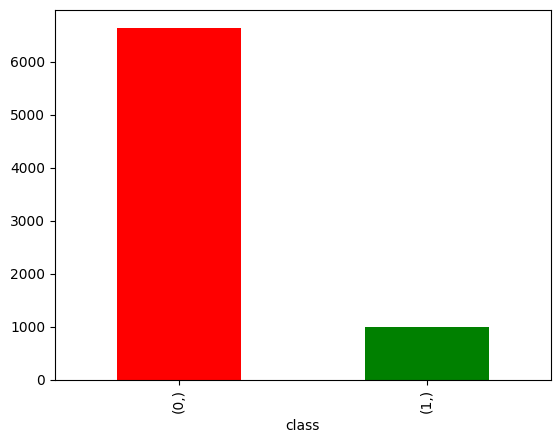

In [11]:
y.value_counts().plot.bar(color=['red', 'green'])

As we can see from the bar chart above, this dataset has two classes `Less Often` and `More Often`. The two labels are imbalanced with most food items should be chosen less often for diabetic patients.


## Build a SVM model with default parameters


First, let's split the training and testing dataset. Training dataset will be used to train and tune models, and testing dataset will be used to evaluate the models. Note that you may also split a validation dataset from the training dataset for model tuning only.


In [12]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

Okay, now we have the training and testing datasets ready, let's start the model training task.


We first define a `sklearn.svm import SVC` model with all default arguments.


In [13]:
model = SVC()

Then train the model with training dataset:


In [14]:
model.fit(X_train, y_train.values.ravel())

SVC()

and make predictions


In [15]:
preds = model.predict(X_test)

Here we defined a utility method to evaluate the model performance.


In [16]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [17]:
evaluate_metrics(y_test, preds)

c:\Users\91879\anaconda3\envs\check\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8704188481675392,
 'recall': 0.0,
 'precision': 0.0,
 'f1score': 0.0}

As we can see from the evaluation results above, the default SVM model achieves relatively good performance on this binary classification task. The overall accuracy is around `0.95` and the f1score is around `0.82`.


Now, you have easily built a SVM model with relatively good performance. Can we achieve better classification performance by customizing the model?


## Train SVM with different regularization parameters and kernels


The `SVC` model provided by sklearn has two important arguments to be tuned: regularization parameter `C` and `kernel`.


The `C` argument is a regularization parameter that controls the trade-off between achieving a low training error and keeping the decision boundary as simple as possible. 

*   For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly, which may cause the model to overfit.
*   Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points, but potentially better generalization to unseen data.


The `kernel` argument specifies the kernel to be used for transforming features to higher-dimensional spaces, some commonly used non-linear kernels are:

*   `rbf`: Gaussian Radial Basis Function (RBF)
*   `poly`: Polynomial Kernel
*   `sigmoid`: Sigmoid Kernel


Let's first try `C = 10` and ` kernel = 'rbf'  `


In [18]:
model = SVC(C=10, kernel='rbf')
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9136125654450262,
 'recall': 0.40404040404040403,
 'precision': 0.851063829787234,
 'f1score': 0.547945205479452}

You should see that we have better performance than the default SVM model trained in the previous step.

## Tune regularization parameter C and Kernels via GridSearch


Exhaustively trying different hyperparameters by hands is infeasible. Thus, `sklearn` provides users with many automatic hyperparameter tuning methods. A popular one is grid search cross-validation `GridSearchCV`


Next, let's quickly try `GridSearchCV` to find the optimized `C` and `kernel` combination:


We first define some candidate parameter values we want to search in a `dict` object, like the following setting:


In [19]:
params_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

Then, we define a  SVM model


In [20]:
model = SVC()

and use create a `GridSearchCV` method to grid search `params_grid` and find the optimized combination with best `f1` score. The searching process may take several minutes to complete.


In [21]:
# Define a GridSearchCV to search the best parameters
grid_search = GridSearchCV(estimator = model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
# Search the best parameters with training data
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [22]:
best_params

{'C': 100, 'kernel': 'rbf'}

Okay, we can see `C=100` and `kernel=`rbf\`\` seems to produce the highest f1score. Let's quickly try this combination to see the model performance.


In [23]:
model = SVC(C=100, kernel='rbf')
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9456806282722513,
 'recall': 0.7474747474747475,
 'precision': 0.8176795580110497,
 'f1score': 0.7810026385224275}

The best f1score now becomes `0.88` after hyperparameter tuning.


## Plot SVM hyperplane and margin


so far we only obtained plain evaluation metrics and they are not intuitive to help us understand and interpret an SVM model. It would be great to visualize the see actual hyperplains and margins learned in an SVM model.

Since it is challenging to visualize a hyperplane higher than 3 dimensions. To illustrate the idea, we will focus on a 2-dimensional feature space.


We first simplify the dataset with only two features `Calories` and `Dietary Fiber`, and include only 1000 instances:


In [24]:
simplified_food_df = food_df[['Calories', 'Dietary Fiber', 'class']]

In [25]:
X = simplified_food_df.iloc[:1000, :-1].values
y = simplified_food_df.iloc[:1000, -1:].values

and we undersample the majority class `Class = 0` to balance the class distribution so we will produce a clearer visualization.


In [26]:
under_sampler = RandomUnderSampler(random_state=rs)
X_under, y_under = under_sampler.fit_resample(X, y)

In [27]:
print(f"Dataset resampled shape, X: {X_under.shape}, y: {y_under.shape}")

Dataset resampled shape, X: (62, 2), y: (62,)


To better show the hyperplane and margins, we normalize the features with a `MinMaxScaler`.


In [28]:
scaler = MinMaxScaler()
X_under = scaler.fit_transform(X_under)

Okay, let's first train a linear SVM model with `kernel=linear` so that we can get a linear hyperplane and margins.


In [29]:
linear_svm = SVC(C=1000, kernel='linear')
linear_svm.fit(X_under, y_under)

SVC(C=1000, kernel='linear')

Here we also provided an utility method to plot the decision boundary (hyperplane), support vectors, and margins. You may write your own visualization method if you are interested.


In [30]:
def plot_decision_boundry(X, y, model):
    plt.figure(figsize=(16, 12))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(
        XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )

    # plot support vectors
    ax.scatter(
        model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.show()

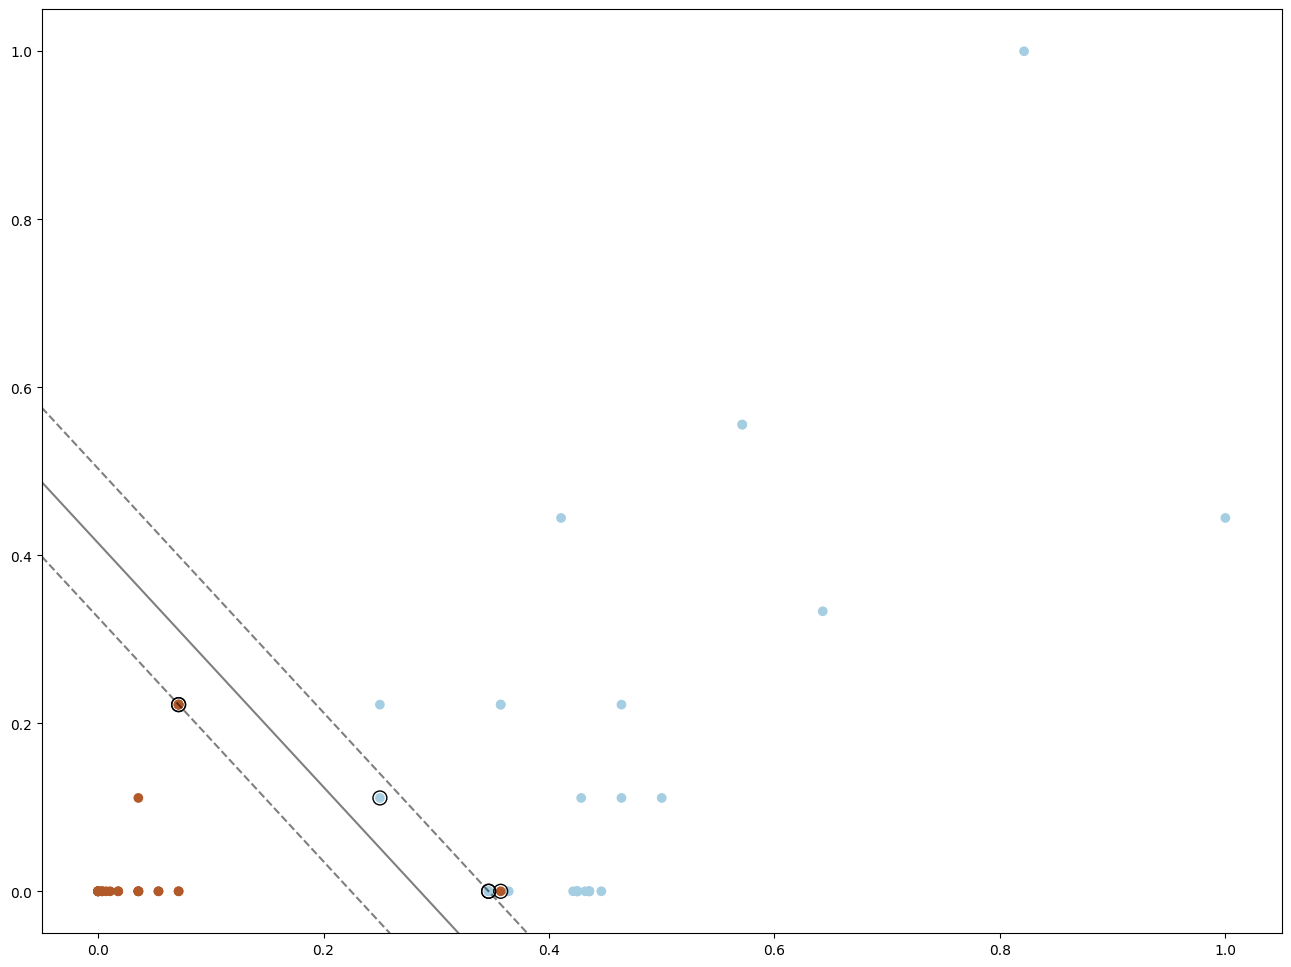

In [31]:
plot_decision_boundry(X_under, y_under, linear_svm)

Okay, we can see a clear linear hyperplane seperates the two classes (Blue dots vs Orange dots). The highlighted dots are the support vectors determining the hyperplain.


If we want to include non-linear kernels, we should get a non-linear decision boundary in the 2-d space (maybe linear in higher feature space). So here we use a `rbf` kernel:


In [32]:
svm_rbf_kernel = SVC(C=100, kernel='rbf')
svm_rbf_kernel.fit(X_under, y_under)

SVC(C=100)

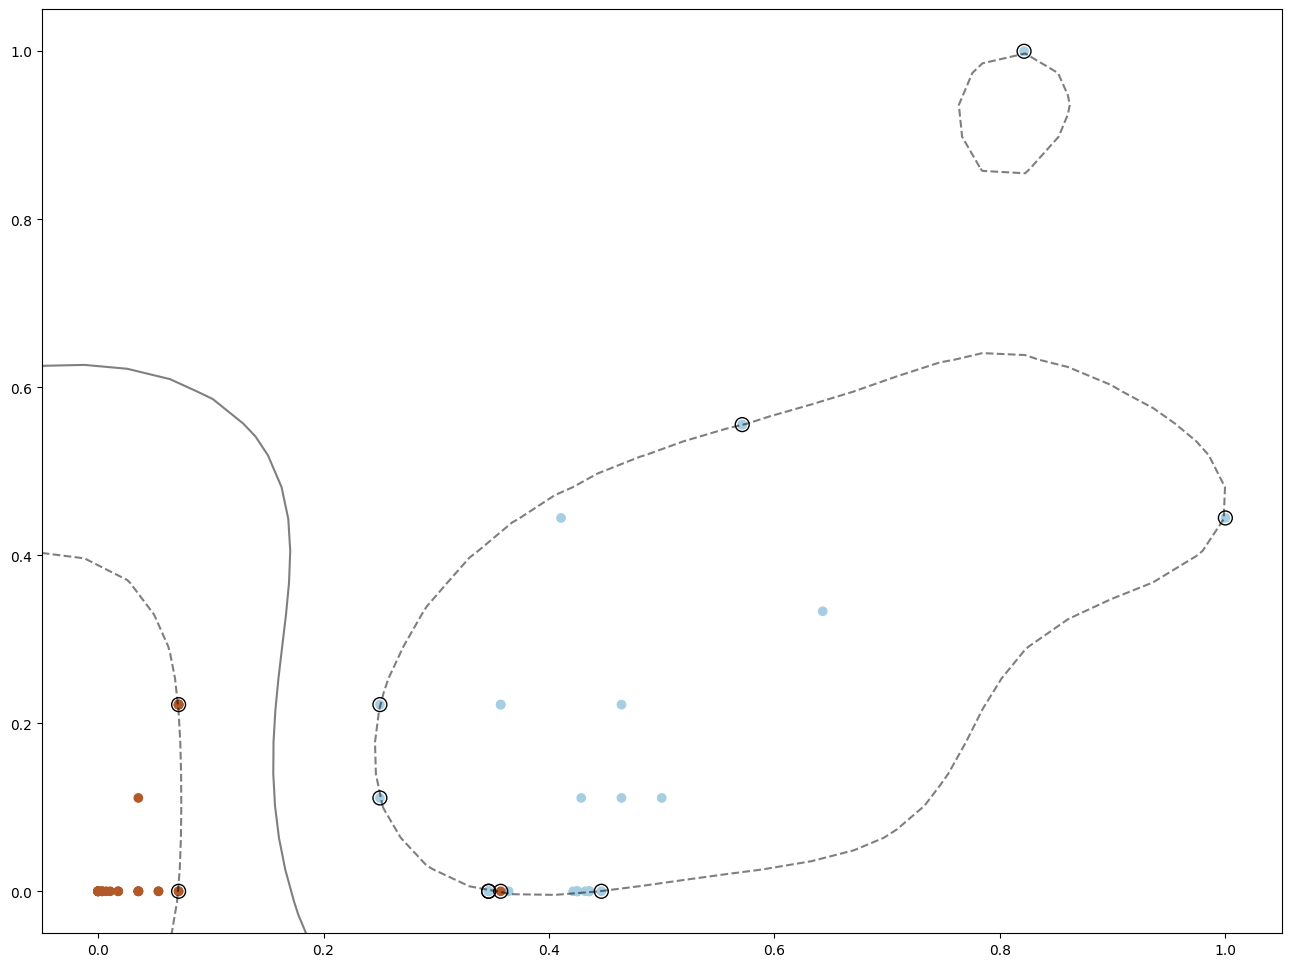

In [33]:
plot_decision_boundry(X_under, y_under, svm_rbf_kernel)

We now see a non-linear hyperplane and margins separating the two classes.


### Try different `C` values and `kernels` to see the how they affect the hyperplanes and margins.


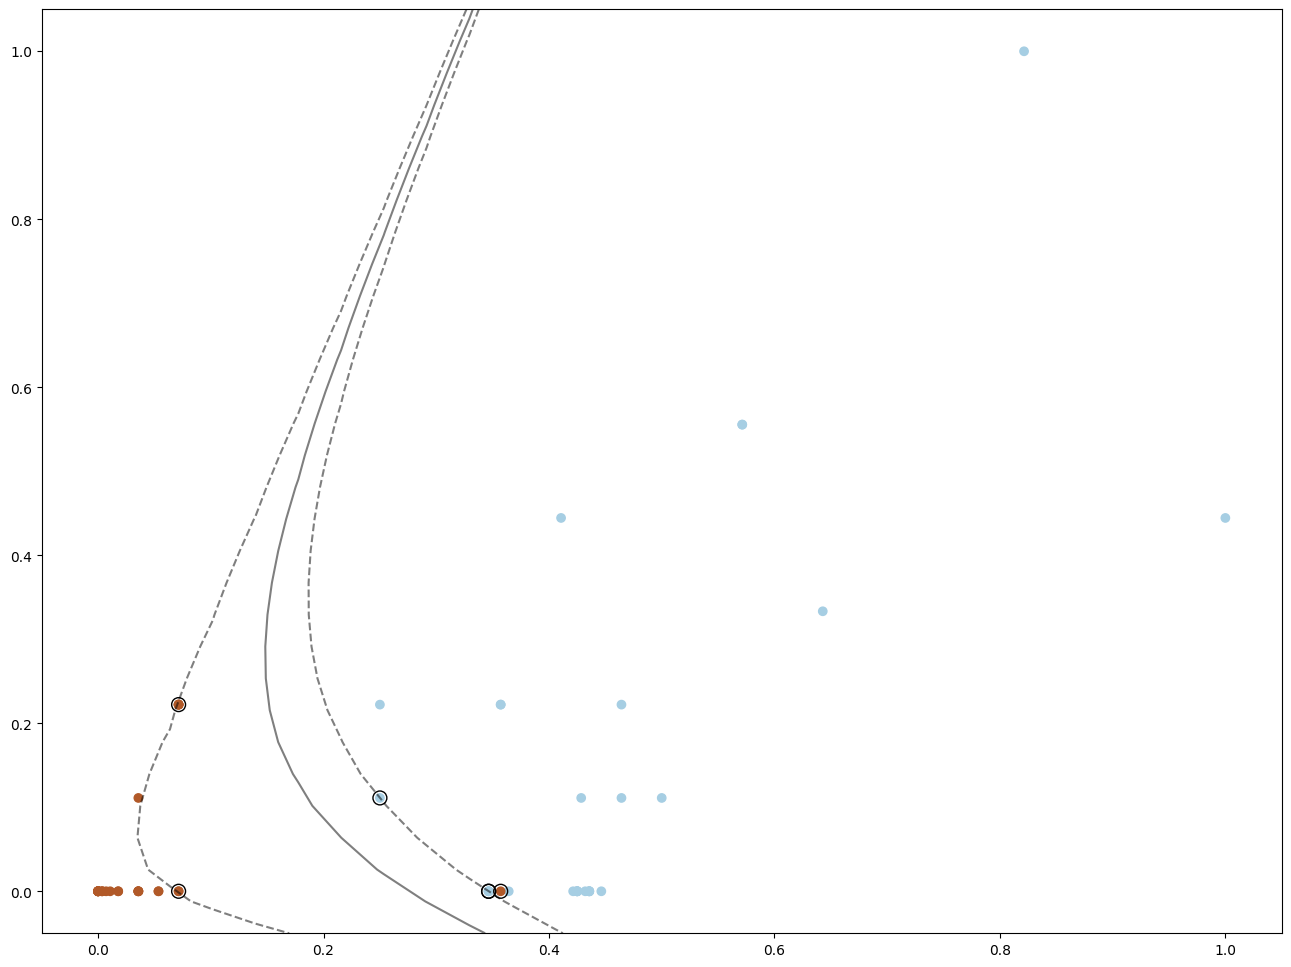

In [34]:
svm_rbf_kernel = SVC(C=100, kernel='poly')
svm_rbf_kernel.fit(X_under, y_under)
plot_decision_boundry(X_under, y_under, svm_rbf_kernel)

#### Problem - SVMs with RBF kernels are very slow in some cases
#### Solution - Construct approximate kernel map with SGD using Nystroem or RBF Sampler i.e., create a dataset in higher dimension and then use LinearSVC as usual

In [35]:
from sklearn.kernel_approximation import Nystroem, RBFSampler

NystroemSVC = Nystroem(kernel="rbf", gamma=1.0, n_components=100)
RBFSamplerSVC  = RBFSampler(gamma=1.0, n_components=100)

X_train_nsc = NystroemSVC.fit_transform(X_train)
X_test_nsc= NystroemSVC.transform(X_test)
X_train_rbf = RBFSamplerSVC.fit_transform(X_train)
X_test_rbf= RBFSamplerSVC.transform(X_test)

In [36]:
X_train_nsc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc.fit(X_train_nsc, y_train.values.ravel())
y_pred = lsvc.predict(X_test_nsc)
accuracy_score(y_test.values.ravel(), y_pred)

c:\Users\91879\anaconda3\envs\check\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8704188481675392